# Introduction to Cartesian Genetic Programming (CGP)

This tutorial provides a hands-on introduction to Cartesian Genetic Programming, a form of genetic programming that represents programs as directed acyclic graphs. We'll build a complete CGP implementation from scratch and demonstrate it on two classic problems: symbolic regression and reinforcement learning policy evolution.

## What is Cartesian Genetic Programming?

Cartesian Genetic Programming (CGP) is a form of genetic programming that represents programs as directed acyclic graphs arranged in a Cartesian (grid-like) coordinate system. Unlike traditional tree-based GP, CGP uses a linear genome that encodes graph connectivity.

## 1. Representation

### Historical Grid Layout

Traditionally, CGP arranges computational nodes in a rectangular grid where:
- Input nodes are on the left
- Function nodes are in the middle (arranged in columns and rows)  
- Output nodes are on the right
- Connections flow from left to right with some recurrency allowed

### Our Simplified Representation

For this tutorial, we'll use a simplified single-row representation where each gene represents a computational node with three components: `[input_x, input_y, function]`. This linear representation is common in current CGP implementations.

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from typing import List, Callable, Tuple, Any

class CGPProgram:
    """A simple CGP implementation with standard node indexing."""
    
    def __init__(self, n_inputs: int, n_outputs: int, n_nodes: int, function_set: List[Callable]):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_nodes = n_nodes
        self.function_set = function_set
        self.n_functions = len(function_set)
        
        # Node indexing:
        # 0 to n_inputs-1: input nodes
        # n_inputs to n_inputs+n_nodes-1: function nodes
        # n_inputs+n_nodes to n_inputs+n_nodes+n_outputs-1: output nodes (virtual)
        
        # Genome: [function_node_genes..., output_genes...]
        # Each function node has 3 genes: [input_x, input_y, function_idx]
        self.genome_length = n_nodes * 3 + n_outputs
        self.genome = None
        
    def create_random_genome(self) -> List[int]:
        """Create a random genome for the CGP program."""
        genome = []
        
        # Create function nodes (node IDs: n_inputs to n_inputs+n_nodes-1)
        for i in range(self.n_nodes):
            node_id = self.n_inputs + i
            # Input connections can point to any previous node (inputs or function nodes)
            max_connection_id = node_id - 1  # Can connect to any node with smaller ID
            
            input_x = random.randint(0, max_connection_id)
            input_y = random.randint(0, max_connection_id)
            function_idx = random.randint(0, self.n_functions - 1)
            genome.extend([input_x, input_y, function_idx])
        
        # Create output genes (point to any node: inputs or function nodes)
        for _ in range(self.n_outputs):
            # Outputs can connect to any input or function node
            output_connection = random.randint(0, self.n_inputs + self.n_nodes - 1)
            genome.append(output_connection)
            
        self.genome = genome
        return genome
    
    def decode_genome(self) -> Tuple[List[Tuple], List[int]]:
        """Decode genome into function node definitions and output connections."""
        function_nodes = []
        
        # Decode function nodes
        for i in range(self.n_nodes):
            start_idx = i * 3
            input_x = self.genome[start_idx]
            input_y = self.genome[start_idx + 1]
            function_idx = self.genome[start_idx + 2]
            function_nodes.append((input_x, input_y, function_idx))
        
        # Decode output connections
        output_start = self.n_nodes * 3
        output_connections = self.genome[output_start:output_start + self.n_outputs]
        
        return function_nodes, output_connections

# Define a simple function set
def safe_divide(x, y):
    """Safe division that handles division by zero."""
    if abs(y) < 1e-10:
        return 1.0
    return x / y

def safe_log(x):
    """Safe logarithm that handles negative values."""
    return math.log(abs(x) + 1e-10)

def safe_sqrt(x):
    """Safe square root that handles negative values."""
    return math.sqrt(abs(x))

# Function set for symbolic regression
FUNCTION_SET = [
    lambda x, y: x + y,      # Addition
    lambda x, y: x - y,      # Subtraction  
    lambda x, y: x * y,      # Multiplication
    lambda x, y: safe_divide(x, y),  # Safe division
    lambda x, y: x,          # Identity (return first input)
    lambda x, y: math.sin(x), # Sine
    lambda x, y: math.cos(x), # Cosine
    lambda x, y: safe_log(x), # Safe logarithm
]

FUNCTION_NAMES = ['+', '-', '*', '/', 'id', 'sin', 'cos', 'log'];

In [2]:
# Create a simple CGP program
cgp = CGPProgram(n_inputs=3, n_outputs=2, n_nodes=5, function_set=FUNCTION_SET)
genome = cgp.create_random_genome()
print("Random genome:", genome)

Random genome: [0, 0, 7, 3, 2, 1, 4, 2, 7, 1, 4, 4, 1, 1, 2, 4, 5]


## 2. Random Initialization

Let's create a function to generate random CGP programs and visualize their structure:

In [3]:
def visualize_genome_structure(cgp: CGPProgram):
    """Visualize the structure of a CGP genome."""
    function_nodes, output_connections = cgp.decode_genome()
    
    print("=== CGP Program Structure ===")
    print(f"Inputs: {cgp.n_inputs} (node IDs 0-{cgp.n_inputs-1})")
    print(f"Function nodes: {cgp.n_nodes} (node IDs {cgp.n_inputs}-{cgp.n_inputs+cgp.n_nodes-1})")
    print(f"Outputs: {cgp.n_outputs}")
    print()
    
    print("Function Nodes:")
    for i, (input_x, input_y, func_idx) in enumerate(function_nodes):
        node_id = cgp.n_inputs + i
        func_name = FUNCTION_NAMES[func_idx]
        print(f"  Node {node_id}: {func_name}(node_{input_x}, node_{input_y})")
    
    print(f"\nOutput Connections:")
    for i, output_connection in enumerate(output_connections):
        print(f"  Output {i}: connects to node {output_connection}")

In [4]:
# Demonstrate random initialization
cgp.create_random_genome()
visualize_genome_structure(cgp)

=== CGP Program Structure ===
Inputs: 3 (node IDs 0-2)
Function nodes: 5 (node IDs 3-7)
Outputs: 2

Function Nodes:
  Node 3: log(node_0, node_1)
  Node 4: -(node_1, node_2)
  Node 5: /(node_3, node_0)
  Node 6: log(node_5, node_1)
  Node 7: log(node_3, node_0)

Output Connections:
  Output 0: connects to node 5
  Output 1: connects to node 1


## 3. Active Graph / Inactive Graph

One key feature of CGP is that not all nodes in the genome are necessarily used in the final computation. Let's implement program execution and identify which nodes are active:

In [5]:
class CGPExecutor:
    """Executes CGP programs using a simple node buffer approach."""
    
    def __init__(self, cgp_program: CGPProgram):
        self.cgp = cgp_program
        
    def execute(self, inputs: List[float]) -> List[float]:
        """Execute the CGP program on given inputs using node buffer."""
        function_nodes, output_connections = self.cgp.decode_genome()
        
        # Initialize node buffer: inputs + function nodes
        total_nodes = self.cgp.n_inputs + self.cgp.n_nodes
        node_buffer = [0.0] * total_nodes
        
        # Set input values in buffer
        for i, inp in enumerate(inputs):
            node_buffer[i] = inp
        
        # Calculate function nodes in order (they can reference earlier nodes only)
        for i, (input_x, input_y, func_idx) in enumerate(function_nodes):
            node_id = self.cgp.n_inputs + i
            val_x = node_buffer[input_x]
            val_y = node_buffer[input_y]
            result = self.cgp.function_set[func_idx](val_x, val_y)
            if math.isnan(result) or math.isinf(result):
                result = 0.0
            node_buffer[node_id] = result

        # Get output values by looking up output connections
        outputs = []
        for output_connection in output_connections:
            outputs.append(node_buffer[output_connection])
        
        return outputs
    
    def find_active_nodes(self) -> set:
        """Find which nodes are actually used in computation."""
        function_nodes, output_connections = self.cgp.decode_genome()
        active_nodes = set()
        
        # Start from output connections and work backwards
        to_check = list(output_connections)
        
        while to_check:
            node_id = to_check.pop()
            
            if node_id in active_nodes:
                continue
                
            active_nodes.add(node_id)
            
            # If this is a function node, add its inputs to check
            if node_id >= self.cgp.n_inputs:
                func_node_idx = node_id - self.cgp.n_inputs
                if func_node_idx < len(function_nodes):
                    input_x, input_y, _ = function_nodes[func_node_idx]
                    to_check.extend([input_x, input_y])
        
        return active_nodes
    
    def visualize_execution(self, inputs: List[float]):
        """Visualize the execution process with node buffer."""
        active_nodes = self.find_active_nodes()
        function_nodes, output_connections = self.cgp.decode_genome()
        
        print(f"=== Execution Analysis ===")
        print(f"Test inputs: {inputs}")
        print(f"Active nodes: {sorted(active_nodes)}")
        all_nodes = set(range(self.cgp.n_inputs + self.cgp.n_nodes))
        inactive_nodes = all_nodes - active_nodes
        print(f"Inactive nodes: {sorted(inactive_nodes)}")
        print()
        
        # Execute with detailed output
        total_nodes = self.cgp.n_inputs + self.cgp.n_nodes
        node_buffer = [0.0] * total_nodes
        
        # Set inputs
        print("Node Buffer Initialization:")
        for i, inp in enumerate(inputs):
            node_buffer[i] = inp
            status = "ACTIVE" if i in active_nodes else "inactive"
            print(f"  Node {i} (Input): {inp:.3f} [{status}]")
        
        print("\nFunction Node Computation:")
        # Calculate function nodes
        for i, (input_x, input_y, func_idx) in enumerate(function_nodes):
            node_id = self.cgp.n_inputs + i
            val_x = node_buffer[input_x]
            val_y = node_buffer[input_y]
            result = self.cgp.function_set[func_idx](val_x, val_y)
            if math.isnan(result) or math.isinf(result):
                result = 0.0
            node_buffer[node_id] = result
            
            func_name = FUNCTION_NAMES[func_idx]
            status = "ACTIVE" if node_id in active_nodes else "inactive"
            print(f"  Node {node_id}: {func_name}({val_x:.3f}, {val_y:.3f}) = {result:.3f} [{status}]")
        
        # Show outputs
        print(f"\nFinal Outputs:")
        for i, output_connection in enumerate(output_connections):
            output_value = node_buffer[output_connection]
            print(f"  Output {i}: node_{output_connection} = {output_value:.3f}")

In [6]:
# Demonstrate active/inactive nodes
executor = CGPExecutor(cgp)
test_inputs = [2.0, 3.0, -1.0]
executor.visualize_execution(test_inputs)

=== Execution Analysis ===
Test inputs: [2.0, 3.0, -1.0]
Active nodes: [0, 1, 3, 5]
Inactive nodes: [2, 4, 6, 7]

Node Buffer Initialization:
  Node 0 (Input): 2.000 [ACTIVE]
  Node 1 (Input): 3.000 [ACTIVE]
  Node 2 (Input): -1.000 [inactive]

Function Node Computation:
  Node 3: log(2.000, 3.000) = 0.693 [ACTIVE]
  Node 4: -(3.000, -1.000) = 4.000 [inactive]
  Node 5: /(0.693, 2.000) = 0.347 [ACTIVE]
  Node 6: log(0.347, 3.000) = -1.060 [inactive]
  Node 7: log(0.693, 2.000) = -0.367 [inactive]

Final Outputs:
  Output 0: node_5 = 0.347
  Output 1: node_1 = 3.000


## 4. Mutation

CGP typically uses point mutation where individual genes are randomly changed.

In [7]:
def mutate_genome(cgp: CGPProgram, mutation_rate: float = 0.1) -> CGPProgram:
    """Mutate a CGP genome using point mutation."""
    new_cgp = CGPProgram(cgp.n_inputs, cgp.n_outputs, cgp.n_nodes, cgp.function_set)
    new_cgp.genome = cgp.genome.copy()
    
    function_nodes, output_connections = cgp.decode_genome()
    
    # Mutate function nodes
    for i in range(cgp.n_nodes):
        if random.random() < mutation_rate:
            gene_to_mutate = random.randint(0, 2)  # 0=input_x, 1=input_y, 2=function
            start_idx = i * 3
            node_id = cgp.n_inputs + i
            
            if gene_to_mutate == 0 or gene_to_mutate == 1:  # Mutate input connection
                # Can connect to any node with smaller ID
                max_connection_id = node_id - 1
                new_cgp.genome[start_idx + gene_to_mutate] = random.randint(0, max_connection_id)
            else:  # Mutate function
                new_cgp.genome[start_idx + 2] = random.randint(0, cgp.n_functions - 1)
    
    # Mutate output connections
    output_start = cgp.n_nodes * 3
    for i in range(cgp.n_outputs):
        if random.random() < mutation_rate:
            # Can connect to any input or function node
            new_connection = random.randint(0, cgp.n_inputs + cgp.n_nodes - 1)
            new_cgp.genome[output_start + i] = new_connection
    
    return new_cgp

In [8]:
def compare_programs(cgp1: CGPProgram, cgp2: CGPProgram, test_inputs: List[List[float]]):
    """Compare the behavior of two CGP programs."""
    executor1 = CGPExecutor(cgp1)
    executor2 = CGPExecutor(cgp2)
    
    print("=== Program Comparison ===")
    print("Original vs Mutated behavior:")
    
    for i, inputs in enumerate(test_inputs):
        output1 = executor1.execute(inputs)
        output2 = executor2.execute(inputs)
        same = all(abs(o1 - o2) < 1e-10 for o1, o2 in zip(output1, output2))
        print(f"  Input {inputs}: {[f'{x:.3f}' for x in output1]} vs {[f'{x:.3f}' for x in output2]} {'(same)' if same else '(different)'}")

In [9]:
# Demonstrate mutation
print("Original program:")
visualize_genome_structure(cgp)

mutated_cgp = mutate_genome(cgp, mutation_rate=0.3)
print("\nMutated program:")
visualize_genome_structure(mutated_cgp)

# Compare behaviors
test_cases = [[1.0, 2.0, -0.5], [0.5, -1.0, 1.5], [3.0, 0.0, -2.0]]
compare_programs(cgp, mutated_cgp, test_cases)

Original program:
=== CGP Program Structure ===
Inputs: 3 (node IDs 0-2)
Function nodes: 5 (node IDs 3-7)
Outputs: 2

Function Nodes:
  Node 3: log(node_0, node_1)
  Node 4: -(node_1, node_2)
  Node 5: /(node_3, node_0)
  Node 6: log(node_5, node_1)
  Node 7: log(node_3, node_0)

Output Connections:
  Output 0: connects to node 5
  Output 1: connects to node 1

Mutated program:
=== CGP Program Structure ===
Inputs: 3 (node IDs 0-2)
Function nodes: 5 (node IDs 3-7)
Outputs: 2

Function Nodes:
  Node 3: log(node_0, node_1)
  Node 4: -(node_1, node_2)
  Node 5: sin(node_3, node_0)
  Node 6: log(node_5, node_1)
  Node 7: log(node_5, node_0)

Output Connections:
  Output 0: connects to node 6
  Output 1: connects to node 1
=== Program Comparison ===
Original vs Mutated behavior:
  Input [1.0, 2.0, -0.5]: ['0.000', '2.000'] vs ['-22.333', '2.000'] (different)
  Input [0.5, -1.0, 1.5]: ['-1.386', '-1.000'] vs ['-0.448', '-1.000'] (different)
  Input [3.0, 0.0, -2.0]: ['0.366', '0.000'] vs ['-

## 5. Evolution: Simple (1+λ) Algorithm

Now let's implement a simple evolutionary algorithm that uses the (1+λ) strategy common in CGP:

In [10]:
class CGPEvolution:
    """Simple (1+λ) evolutionary algorithm for CGP."""
    
    def __init__(self, fitness_function: Callable, population_size: int = 4, mutation_rate: float = 0.1):
        self.fitness_function = fitness_function
        self.population_size = population_size  # This is λ
        self.mutation_rate = mutation_rate
        
    def evolve(self, initial_cgp: CGPProgram, generations: int = 100, target_fitness: float = None) -> Tuple[CGPProgram, List[float]]:
        """Evolve a CGP program using (1+λ) strategy."""
        current_best = initial_cgp
        current_fitness = self.fitness_function(current_best)
        
        fitness_history = [current_fitness]
        
        print(f"Generation 0: fitness = {current_fitness:.6f}")
        
        for generation in range(1, generations + 1):
            # Generate λ offspring by mutation
            offspring = []
            for _ in range(self.population_size):
                child = mutate_genome(current_best, self.mutation_rate)
                offspring.append(child)
            
            # Evaluate offspring
            best_offspring = None
            best_offspring_fitness = float('inf')
            
            for child in offspring:
                child_fitness = self.fitness_function(child)
                if child_fitness < best_offspring_fitness:
                    best_offspring = child
                    best_offspring_fitness = child_fitness
            
            # Selection: keep best (1+λ strategy with elitism)
            if best_offspring_fitness <= current_fitness:
                current_best = best_offspring
                current_fitness = best_offspring_fitness
            
            fitness_history.append(current_fitness)
            
            if generation % 5 == 0:
                print(f"Generation {generation}: fitness = {current_fitness:.6f}")
            
            # Check for target fitness
            if target_fitness is not None and current_fitness <= target_fitness:
                print(f"Target fitness reached at generation {generation}")
                break
        
        return current_best, fitness_history

In [11]:
# Example fitness function for demonstration
def dummy_fitness(cgp: CGPProgram) -> float:
    """A dummy fitness function that prefers longer programs."""
    executor = CGPExecutor(cgp)
    active_nodes = executor.find_active_nodes()
    
    # Prefer programs with more active nodes
    program_size = -len(active_nodes)    
    return program_size

In [12]:
# Demonstrate evolution (with dummy fitness)
print("=== Evolution Demo ===")
cgp_initial = CGPProgram(n_inputs=2, n_outputs=1, n_nodes=8, function_set=FUNCTION_SET)
cgp_initial.create_random_genome()

evolution = CGPEvolution(dummy_fitness, population_size=5, mutation_rate=0.15)
best_cgp, fitness_history = evolution.evolve(cgp_initial, generations=50)

print(f"\nBest program found:")
visualize_genome_structure(best_cgp)

=== Evolution Demo ===
Generation 0: fitness = -1.000000
Generation 5: fitness = -7.000000
Generation 10: fitness = -7.000000
Generation 15: fitness = -7.000000
Generation 20: fitness = -8.000000
Generation 25: fitness = -8.000000
Generation 30: fitness = -8.000000
Generation 35: fitness = -8.000000
Generation 40: fitness = -8.000000
Generation 45: fitness = -8.000000
Generation 50: fitness = -9.000000

Best program found:
=== CGP Program Structure ===
Inputs: 2 (node IDs 0-1)
Function nodes: 8 (node IDs 2-9)
Outputs: 1

Function Nodes:
  Node 2: /(node_0, node_0)
  Node 3: *(node_1, node_0)
  Node 4: cos(node_2, node_2)
  Node 5: sin(node_4, node_3)
  Node 6: *(node_2, node_4)
  Node 7: *(node_6, node_5)
  Node 8: -(node_4, node_5)
  Node 9: sin(node_7, node_5)

Output Connections:
  Output 0: connects to node 9


## 6. Example 1: Symbolic Regression

Let's apply our CGP implementation to symbolic regression - evolving a program to approximate a target mathematical function:

In [13]:
def symbolic_regression_fitness(target_function: Callable, test_points: List[List[float]]) -> Callable:
    """Create a fitness function for symbolic regression."""
    
    def fitness(cgp: CGPProgram) -> float:
        executor = CGPExecutor(cgp)
        total_error = 0.0
        
        for inputs in test_points:
            try:
                predicted = executor.execute(inputs)[0]
                target = target_function(*inputs)
                error = abs(predicted - target)
                total_error += error
            except:
                # Penalize programs that crash
                total_error += 1000.0
        
        return total_error / len(test_points)
    
    return fitness

In [14]:
# Define target function: f(x, y) = x^2 + y^2
def target_function(x, y):
    return x*x + y*y

# Generate test points
np.random.seed(42)
test_points = []
for _ in range(20):
    x = np.random.uniform(-3, 3)
    y = np.random.uniform(-3, 3)
    test_points.append([x, y])

print("=== Symbolic Regression: f(x,y) = x² + y² ===")
print(f"Using {len(test_points)} test points")

=== Symbolic Regression: f(x,y) = x² + y² ===
Using 20 test points


In [15]:
# Create fitness function
sr_fitness = symbolic_regression_fitness(target_function, test_points)

# Initialize and evolve
cgp_sr = CGPProgram(n_inputs=2, n_outputs=1, n_nodes=15, function_set=FUNCTION_SET)
cgp_sr.create_random_genome()

print(f"Initial fitness: {sr_fitness(cgp_sr):.6f}")

Initial fitness: 6.507624


In [16]:
evolution_sr = CGPEvolution(sr_fitness, population_size=6, mutation_rate=0.12)
best_sr, fitness_history_sr = evolution_sr.evolve(cgp_sr, generations=200, target_fitness=0.1)

print(f"\nFinal fitness: {sr_fitness(best_sr):.6f}")
print("Best evolved program:")
visualize_genome_structure(best_sr)

Generation 0: fitness = 6.507624
Generation 5: fitness = 5.450729
Generation 10: fitness = 2.743204
Generation 15: fitness = 2.719400
Generation 20: fitness = 2.402383
Generation 25: fitness = 2.208688
Generation 30: fitness = 2.208688
Generation 35: fitness = 2.208688
Generation 40: fitness = 2.208688
Generation 45: fitness = 2.208688
Generation 50: fitness = 2.208688
Generation 55: fitness = 2.208688
Generation 60: fitness = 2.208688
Generation 65: fitness = 2.208688
Generation 70: fitness = 2.208688
Generation 75: fitness = 2.208688
Generation 80: fitness = 0.000000
Target fitness reached at generation 80

Final fitness: 0.000000
Best evolved program:
=== CGP Program Structure ===
Inputs: 2 (node IDs 0-1)
Function nodes: 15 (node IDs 2-16)
Outputs: 1

Function Nodes:
  Node 2: *(node_0, node_0)
  Node 3: *(node_1, node_1)
  Node 4: +(node_2, node_1)
  Node 5: id(node_4, node_2)
  Node 6: /(node_2, node_2)
  Node 7: /(node_1, node_5)
  Node 8: cos(node_7, node_4)
  Node 9: *(node_4, 

In [17]:
# Test the evolved program
print("\n=== Testing Evolved Program ===")
executor_sr = CGPExecutor(best_sr)
print("Sample predictions vs targets:")
for i in range(5):
    x, y = test_points[i]
    predicted = executor_sr.execute([x, y])[0]
    target = target_function(x, y)
    print(f"  f({x:.2f}, {y:.2f}): predicted={predicted:.3f}, target={target:.3f}, error={abs(predicted-target):.3f}")


=== Testing Evolved Program ===
Sample predictions vs targets:
  f(-0.75, 2.70): predicted=7.880, target=7.880, error=0.000
  f(1.39, 0.59): predicted=2.288, target=2.288, error=0.000
  f(-2.06, -2.06): predicted=8.520, target=8.520, error=0.000
  f(-2.65, 2.20): predicted=11.858, target=11.858, error=0.000
  f(0.61, 1.25): predicted=1.927, target=1.927, error=0.000


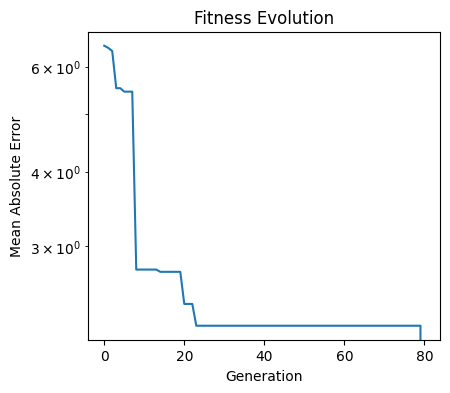

In [18]:
# Plot fitness evolution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fitness_history_sr)
plt.title('Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Mean Absolute Error')
plt.yscale('log')

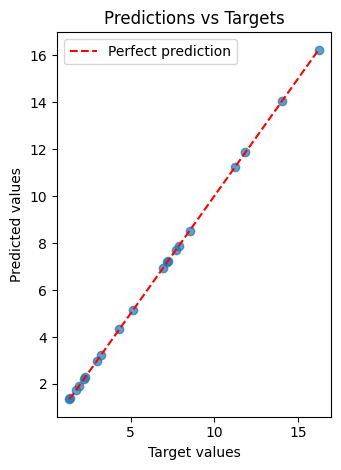

In [19]:
# Plot predictions vs targets
plt.subplot(1, 2, 2)
predictions = [executor_sr.execute(point)[0] for point in test_points]
targets = [target_function(*point) for point in test_points]
plt.scatter(targets, predictions, alpha=0.7)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label='Perfect prediction')
plt.xlabel('Target values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Targets')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Example 2: Reinforcement Learning Policy

For our final example, let's evolve a policy for the Mountain Car problem. We'll create a simplified version that evolves a control policy:

In [20]:
# Install gymnasium if not already installed
# !pip install gymnasium[classic_control]

In [21]:
import gymnasium as gym

In [22]:
def evaluate_policy(cgp: CGPProgram, episodes: int = 5, max_steps: int = 200, render: bool = False) -> float:
    """Evaluate a CGP policy on Mountain Car using gymnasium."""
    if render:
        env = gym.make('MountainCar-v0', render_mode='human')
    else:
        env = gym.make('MountainCar-v0')
    
    executor = CGPExecutor(cgp)
    
    total_reward = 0.0
    total_steps = 0
    success_count = 0
    
    for episode in range(episodes):
        observation, info = env.reset()
        episode_reward = 0.0
        
        for step in range(max_steps):
            try:
                # Use CGP to select action
                # observation[0] = position, observation[1] = velocity
                policy_outputs = executor.execute([observation[0], observation[1]])
                
                # Use argmax to select action from 3 outputs
                # output[0] = preference for left (action 0)
                # output[1] = preference for nothing (action 1) 
                # output[2] = preference for right (action 2)
                action = policy_outputs.index(max(policy_outputs))
                
                observation, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                
                if terminated:  # Reached the goal
                    success_count += 1
                    # Bonus for reaching goal quickly
                    episode_reward += (max_steps - step) * 0.1
                    break
                    
                if truncated:  # Time limit reached
                    break
                    
            except Exception as e:
                # Penalize policies that crash
                episode_reward -= 100
                break
        
        total_reward += episode_reward
        total_steps += step + 1
    
    env.close()
    
    # Fitness: negative total reward (we want to maximize reward)
    # Add penalty for longer episodes to encourage efficiency
    avg_steps = total_steps / episodes
    step_penalty = avg_steps / max_steps
    success_rate = success_count / episodes
    
    # Lower fitness is better: negative reward + step penalty - success bonus
    fitness = -(total_reward / episodes) + step_penalty - (success_rate * 10)
    
    return fitness

In [23]:
def test_policy_with_visualization(cgp: CGPProgram, episodes: int = 3):
    """Test policy with gymnasium's built-in visualization."""
    print("=== Testing Policy with Visualization ===")
    print("Close the rendering window to continue to the next episode.")
    
    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")
        env = gym.make('MountainCar-v0', render_mode='human')
        executor = CGPExecutor(cgp)
        
        observation, info = env.reset()
        total_reward = 0
        steps = 0
        max_steps = 200
        
        for step in range(max_steps):
            try:
                policy_outputs = executor.execute([observation[0], observation[1]])
                action = policy_outputs.index(max(policy_outputs))
                
                observation, reward, terminated, truncated, info = env.step(action)
                total_reward += reward
                steps += 1
                
                if terminated:
                    print(f"  SUCCESS! Reached goal in {steps} steps")
                    break
                    
                if truncated:
                    print(f"  Time limit reached ({steps} steps)")
                    break
                    
            except Exception as e:
                print(f"  Policy crashed: {e}")
                break
        
        print(f"  Total reward: {total_reward}")
        env.close()

In [24]:
print("=== Mountain Car Policy Evolution ===")

# Create CGP for policy (2 inputs: position, velocity; 3 outputs: action preferences)
cgp_policy = CGPProgram(n_inputs=2, n_outputs=3, n_nodes=12, function_set=FUNCTION_SET)
cgp_policy.create_random_genome()

print(f"Initial policy fitness: {evaluate_policy(cgp_policy):.3f}")

# Evolve policy (this may take a few minutes)
evolution_policy = CGPEvolution(evaluate_policy, population_size=8, mutation_rate=0.1)
best_policy, fitness_history_policy = evolution_policy.evolve(cgp_policy, generations=150, target_fitness=-5.0)

print(f"\nFinal policy fitness: {evaluate_policy(best_policy):.3f}")
print("Best evolved policy:")
visualize_genome_structure(best_policy)

=== Mountain Car Policy Evolution ===
Initial policy fitness: 201.000
Generation 0: fitness = 201.000000
Generation 5: fitness = 201.000000
Generation 10: fitness = 189.857000
Generation 15: fitness = 86.588000
Generation 20: fitness = 84.820000
Generation 25: fitness = 70.455000
Generation 30: fitness = 70.455000
Generation 35: fitness = 70.455000
Generation 40: fitness = 70.455000
Generation 45: fitness = 70.455000
Generation 50: fitness = 70.455000
Generation 55: fitness = 70.455000
Generation 60: fitness = 70.455000
Generation 65: fitness = 70.455000
Generation 70: fitness = 70.455000
Generation 75: fitness = 70.455000
Generation 80: fitness = 70.455000
Generation 85: fitness = 70.455000
Generation 90: fitness = 70.455000
Generation 95: fitness = 70.455000
Generation 100: fitness = 70.455000
Generation 105: fitness = 70.455000
Generation 110: fitness = 67.803000
Generation 115: fitness = 67.803000
Generation 120: fitness = 67.803000
Generation 125: fitness = 67.803000
Generation 13

In [26]:
# Show example action selection
print("\n=== Policy Action Selection Examples ===")
test_states = [[-0.6, 0.0], [-0.4, -0.02], [-0.2, 0.01], [0.0, 0.03]]
action_names = ['Left', 'Nothing', 'Right']
executor_policy = CGPExecutor(best_policy)

for state in test_states:
    outputs = executor_policy.execute(state)
    action = outputs.index(max(outputs))
    print(f"State [pos={state[0]:.2f}, vel={state[1]:.3f}]: outputs={[f'{x:.3f}' for x in outputs]} → Action: {action} ({action_names[action]})")


=== Policy Action Selection Examples ===
State [pos=-0.60, vel=0.000]: outputs=['0.841', '0.841', '0.000'] → Action: 0 (Left)
State [pos=-0.40, vel=-0.020]: outputs=['-0.020', '-0.020', '-0.020'] → Action: 0 (Left)
State [pos=-0.20, vel=0.010]: outputs=['0.010', '0.010', '0.010'] → Action: 2 (Right)
State [pos=0.00, vel=0.030]: outputs=['0.030', '0.030', '0.030'] → Action: 2 (Right)


In [27]:
# Test the evolved policy without visualization first
def test_policy_performance(cgp: CGPProgram, test_episodes: int = 20):
    """Test policy performance without visualization."""
    print(f"\n=== Testing Evolved Policy Performance ===")
    
    success_count = 0
    total_steps = 0
    total_rewards = 0
    
    for episode in range(test_episodes):
        env = gym.make('MountainCar-v0')
        executor = CGPExecutor(cgp)
        
        observation, info = env.reset()
        episode_reward = 0
        steps = 0
        max_steps = 200
        
        for step in range(max_steps):
            policy_outputs = executor.execute([observation[0], observation[1]])
            action = policy_outputs.index(max(policy_outputs))
            
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            
            if terminated:
                success_count += 1
                break
                
            if truncated:
                break
        
        total_steps += steps
        total_rewards += episode_reward
        env.close()
    
    success_rate = success_count / test_episodes
    avg_steps = total_steps / test_episodes
    avg_reward = total_rewards / test_episodes
    
    print(f"Success rate: {success_rate:.1%} ({success_count}/{test_episodes})")
    print(f"Average steps per episode: {avg_steps:.1f}")
    print(f"Average reward per episode: {avg_reward:.1f}")
    
    return success_rate

In [28]:
# Test policy performance
success_rate = test_policy_performance(best_policy)


=== Testing Evolved Policy Performance ===
Success rate: 100.0% (20/20)
Average steps per episode: 125.3
Average reward per episode: -125.3


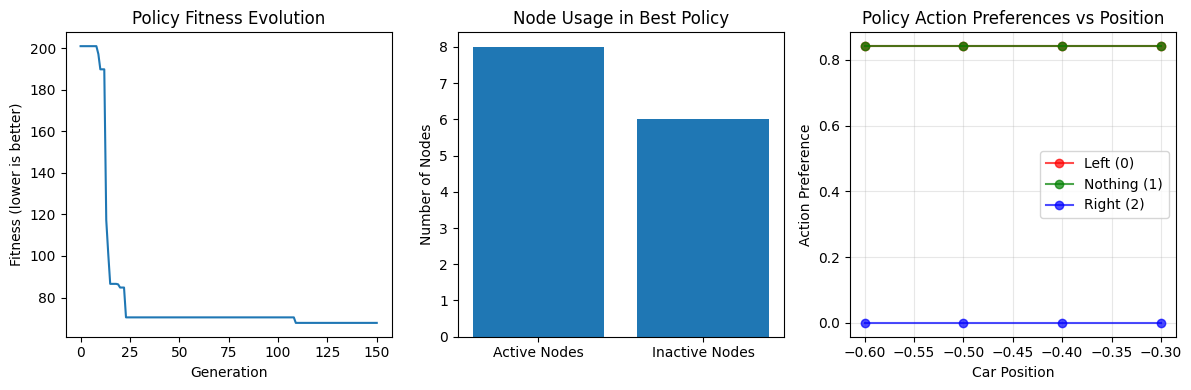

In [29]:
# Plot policy evolution
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(fitness_history_policy)
plt.title('Policy Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Fitness (lower is better)')

plt.subplot(1, 3, 2)
# Show active nodes in best policy
executor_policy = CGPExecutor(best_policy)
active_nodes = executor_policy.find_active_nodes()
all_nodes = list(range(best_policy.n_inputs + best_policy.n_nodes))
active_count = len([n for n in all_nodes if n in active_nodes])
inactive_count = len(all_nodes) - active_count

plt.bar(['Active Nodes', 'Inactive Nodes'], [active_count, inactive_count])
plt.title('Node Usage in Best Policy')
plt.ylabel('Number of Nodes')

plt.subplot(1, 3, 3)
# Test policy on a few different starting positions
test_positions = [-0.6, -0.5, -0.4, -0.3]
test_velocities = [0.0]
action_preferences = {'Left': [], 'Nothing': [], 'Right': []}

for pos in test_positions:
    for vel in test_velocities:
        outputs = executor_policy.execute([pos, vel])
        action_preferences['Left'].append(outputs[0])
        action_preferences['Nothing'].append(outputs[1])
        action_preferences['Right'].append(outputs[2])

plt.plot(test_positions, action_preferences['Left'], 'ro-', label='Left (0)', alpha=0.7)
plt.plot(test_positions, action_preferences['Nothing'], 'go-', label='Nothing (1)', alpha=0.7)
plt.plot(test_positions, action_preferences['Right'], 'bo-', label='Right (2)', alpha=0.7)
plt.xlabel('Car Position')
plt.ylabel('Action Preference')
plt.title('Policy Action Preferences vs Position')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

This tutorial demonstrated the key concepts of Cartesian Genetic Programming:

1. **Representation**: Linear genome encoding directed acyclic graphs
2. **Neutrality**: Many mutations don't change program behavior  
3. **Simplicity**: Simple (1+λ) evolution strategy works well
4. **Versatility**: Same framework works for symbolic regression and RL policy evolution

The simplicity of CGP makes it an excellent starting point for exploring genetic programming, while its power makes it suitable for solving complex real-world problems.